In [1]:
import pandas as pd
import numpy as np

**FASE DE IMPORTACIÓN**

In [72]:
fraude = pd.read_csv('Fraude en TC/fraude_tc.csv')

In [73]:
fraude

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


**ANALISIS DE DATOS**

In [74]:
null_columns = fraude.columns[fraude.isna().any()].tolist()
null_columns_type = {null_columns[i] : [fraude[null_columns[i]].isnull().sum(), str(fraude[null_columns[i]].dtype)] for i in range(len(null_columns))}
null_columns_type

{}

* Se descarta la presencia de valores nulos

In [9]:
import matplotlib.pyplot as plt

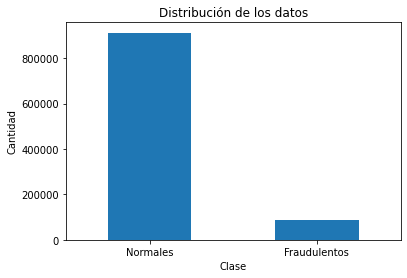

In [75]:
# Cantidad de registros normales vs. fraudulentos
fraude.fraud.value_counts(sort=True).plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normales', 'Fraudulentos'])
plt.title("Distribución de los datos")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

* Esquema de distribución de resultados para la varble categorica dependiente *'fraud'*

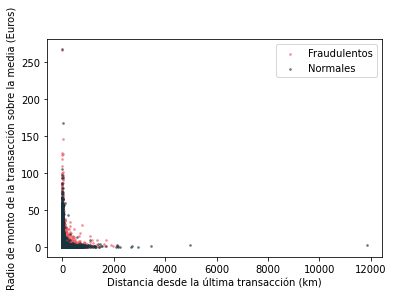

In [76]:
# Monto de las transacciones vs. distancia

normales = fraude[fraude.fraud==0]
fraudulentos = fraude[fraude.fraud==1]
plt.scatter(fraudulentos.distance_from_last_transaction, fraudulentos.ratio_to_median_purchase_price, 
	alpha = 0.5, c='#F2545B', label='Fraudulentos', s=3)
plt.scatter(normales.distance_from_last_transaction, normales.ratio_to_median_purchase_price, 
	alpha = 0.5, c='#19323C', label='Normales', s=3)
plt.xlabel('Distancia desde la última transacción (km)')
plt.ylabel('Radio de monto de la transacción sobre la media (Euros)')
plt.legend(loc='upper right')
plt.show()

* Distribucion del monto en funcion del la distancia desde la ultima transacción, separado por los valores de la columna *'fraud'* 

In [77]:
from sklearn.preprocessing import StandardScaler

fraude['distance_from_home'] = StandardScaler().fit_transform(fraude['distance_from_home'].values.reshape(-1,1))
fraude['distance_from_last_transaction'] = StandardScaler().fit_transform(fraude['distance_from_last_transaction'].values.reshape(-1,1))
fraude['ratio_to_median_purchase_price'] = StandardScaler().fit_transform(fraude['ratio_to_median_purchase_price'].values.reshape(-1,1))

* Antes de empezar con la aplicación de modelos, se genera una estandarización de nuestras variables numericas, esto como parte del **pipeline** de generación del modelo, más separando nuestras variables de manera previa.

**GENERACIÓN DEL MODELO**

In [122]:
X = fraude.drop('fraud', axis=1).values
y = fraude.fraud.values

* Para este modelo dividimos nuestras columnas en primera instancia, en variables independientes y nuestra variable dependiente

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [139]:
X_train.shape

(800000, 7)

In [141]:
X_test.shape

(200000, 7)

* Hacemos una división de la mano de *'train_test_split'* y vemos su distribución

In [124]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
from sklearn.model_selection import RandomizedSearchCV as RSCV

param_grid = {'n_estimators':np.arange(50, 200, 15),
              'max_depth': [5, 7, 9, 11, 13, 15]}

model = RSCV(RandomForestClassifier(), param_grid, n_iter = 15).fit(X_train[:2000], y_train[:2000])
model = model.best_estimator_
model

RandomForestClassifier(max_depth=9, n_estimators=140)

* Usamos una busqueda aleatoria de hiperparametros previo a la generación del modelo, así tenemos una estimación de los parametros que corresponden a nuestro modelo

In [131]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [132]:
model_lin = RandomForestClassifier(max_depth=9, random_state=0, n_estimators=140)

model_lin.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, n_estimators=140, random_state=0)

* Generamos nuestro modelo clasificatorio de RandomForest con los hiperparametros previamente definidos

In [134]:
# Predicción X_test -> Autoencoder -> X_pred
y_pred = model_lin.predict(X_test)

* Usamos nuestro modelo para predecir los resultados de nuestras filas de testeo 

In [144]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[182557      0]
 [     3  17440]]


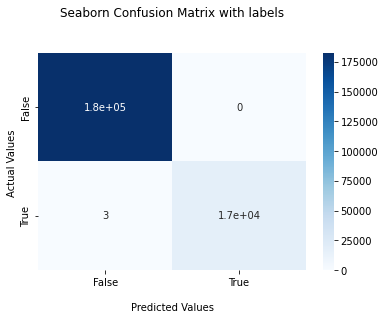

In [145]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

* La matriz de confusión nos da una perspectiva del alcance y los limitantes del modelo. 
* En este caso contamos con **3 falsos neagativos y 0 falsos positivos**, en nuestra muestra.

In [137]:
from sklearn.metrics import mean_squared_log_error

rmsle = round(mean_squared_log_error(y_test, y_pred, squared=False), 2)
print('Nuestro error cuadratico medio logaritmico es {:.2f}'.format(rmsle))

Nuestro error cuadratico medio logaritmico es 0.00


In [146]:
import sklearn.metrics as metrics

y_train_pred = model_lin.predict(X_train)
y_test_pred = model_lin.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

1.0
0.999985


* Segun el *'accuracy_score'* nuestro modelo contaria con una **precisión de 1 en el entrenamiento y 0.99 en el testeo**